# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Download the Dataset

In [3]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 51.9MB/s]
Archive:  spam-messages.zip
  inflating: spam.csv                


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [4]:
df=pd.read_csv("/content/spam.csv")

In [5]:
df.head(5)

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [6]:
df.sample(10)

,text,label
3539,"I'll get there at 3, unless you guys want me t...",ham
4724,There'll be a minor shindig at my place later ...,ham
1740,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...,spam
272,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,spam
5508,"Machan you go to gym tomorrow, i wil come lat...",ham
2162,1) Go to write msg 2) Put on Dictionary mode 3...,ham
2390,First has she gained more than &lt;#&gt; kg s...,ham
5360,"Hey, iouri gave me your number, I'm wylie, rya...",ham
1277,Dont put your phone on silent mode ok,ham
3176,In meeting da. I will call you,ham


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [9]:
df['label'].value_counts()
#the data are imbalenced!

label
ham     4825
spam     747
Name: count, dtype: int64

In [19]:
from sklearn.utils import resample
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

spam_oversampled = resample(spam, replace=True, n_samples=len(ham), random_state=22)

balanced_df = pd.concat([ham, spam_oversampled])
df = balanced_df


In [20]:
df['label'].value_counts()


label
ham     4825
spam    4825
Name: count, dtype: int64

In [21]:
#Analyzing the length of the text data
df['n_words']=df['text'].apply(lambda x: len(x.split())) #spliting the words so we can know the lenght

In [22]:
#here it will show me the n_words in 95% of the data
max_length=int(df['n_words'].quantile(0.95))
print(max_length)

32


In [23]:
#finding the most frequant words
mfw= (df['text'].str.lower().str.split().explode().value_counts())

In [24]:
mfw.head(5)

text
to      6090
a       3444
you     3379
call    2498
i       2423
Name: count, dtype: int64

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [25]:
#1 no missing values:)

In [26]:
#2 Filter by text length

In [27]:
#3 English stopwords loading
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
stopwords=set(stopwords.words("english"))

In [29]:
#4 Text cleaning here we will clean the text from any links punctions and we will do steems
import re
from nltk.stem.isri import ISRIStemmer

In [30]:
sm= ISRIStemmer()
def clean_text(text):
  cleaned_text=re.sub(r"http\s+|www\s+|http\s+",' ', text,flags=re.MULTILINE)
  cleaned_text=re.sub([r"^\w\s"],' ',cleaned_text)
  cleaned_text=text.lower()
  cleaned_text=' '.join((word for word in cleaned_text.split() if word not in stopwords))
  words = cleaned_text.split()
  Stemming_words=[]
  for word in words:
    Stemming_words.append(sm.stem(word))
    Stemming_words=' '.join(cleaned_text)

    return cleaned_text


In [31]:
sm = ISRIStemmer()

def clean_text(text):
    cleaned_text = re.sub(r"http\s+|www\s+|http\s+", ' ', text, flags=re.MULTILINE)
    cleaned_text = cleaned_text.lower()
    cleaned_text = ' '.join(word for word in cleaned_text.split() if word not in stopwords)
    words = cleaned_text.split()
    stemming_words = [sm.stem(word) for word in words]
    cleaned_text = ' '.join(stemming_words)

    return cleaned_text

In [32]:
clean_text(df['text'][1])

'pls dont play others life.'

In [33]:
df['clean_text'] = df['text'].apply(clean_text)

In [34]:
df

,text,label,n_words,clean_text
0,Mm yes dear look how i am hugging you both. :-...,ham,12,mm yes dear look hugging both. :-p https://lin...
1,But pls dont play in others life.,ham,7,pls dont play others life.
2,i can call in &lt;#&gt; min if thats ok http...,ham,10,call &lt;#&gt; min thats ok https://link1.com
3,HMM yeah if your not too grooved out! And im l...,ham,17,hmm yeah grooved out! im looking forward pound...
7,Why de. You looking good only:-)..,ham,6,de. looking good only:-)..
...,...,...,...,...
6484,Please call our customer service representativ...,spam,24,please call customer service representative fr...
6508,FREE UNLIMITED HARDCORE PORN direct 2 your mob...,spam,31,free unlimited hardcore porn direct 2 mobile t...
2850,Do you want a New Nokia 3510i Colour Phone Del...,spam,30,want new nokia 3510i colour phone delivered to...
6334,HMV BONUS SPECIAL 500 pounds of genuine HMV vo...,spam,25,hmv bonus special 500 pounds genuine hmv vouch...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [35]:
#1 Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])

In [36]:
#2 Text to sequences
sequence=tokenizer.texts_to_sequences(df['clean_text'])

In [37]:
#3 Padding the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padd_sequences=pad_sequences(sequence,maxlen=max_length,padding="post")

In [38]:
#4 Label encoding
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder_label= encoder.fit_transform(df['label'])

In [39]:
#5- Train-test split
from sklearn.model_selection import train_test_split
train_data,test_data,train_lebels , test_labels=train_test_split(padd_sequences,encoder_label,test_size=0.2,random_state=2)

In [40]:
#6 Data shape confirmation

print("trin data shape:")
train_data.shape


trin data shape:


(7720, 32)

In [41]:
print("train_lebels shape:")
train_lebels.shape


train_lebels shape:


(7720,)

In [42]:
print("test lebels shape:")
test_data.shape


test lebels shape:


(1930, 32)

In [43]:
print("test lebels shape:")
test_labels.shape


test lebels shape:


(1930,)

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [53]:
#model
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Input ,Bidirectional ,Embedding , SimpleRNN , Dropout


In [60]:

model=Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=33,input_length=max_length),
    Bidirectional(SimpleRNN(64,return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dropout(0.3),
    Dense(20,activation='relu'),
    Dense(1 ,activation='sigmoid')
])

In [61]:
#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 33)            291324    
                                                                 
 bidirectional_6 (Bidirecti  (None, 32, 128)           12544     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                10304     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [62]:
#model compilation
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [63]:
# Batch Size - Training the Mode
batch_size=32
train_dataset= tensorflow.data.Dataset.from_tensor_slices((train_data,train_lebels))
test_dataset= tensorflow.data.Dataset.from_tensor_slices((test_data,test_labels))
train_dataset=train_dataset.batch(batch_size)
test_dataset=test_dataset.batch(batch_size)

In [64]:
#training the model !
history= model.fit(train_dataset,epochs=10,validation_data=test_dataset)

Epoch 1/10
242/242 [==============================] - 23s 77ms/step - loss: 0.1242 - accuracy: 0.9575 - val_loss: 0.0609 - val_accuracy: 0.9881
Epoch 2/10
242/242 [==============================] - 9s 36ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 0.0635 - val_accuracy: 0.9855
Epoch 3/10
242/242 [==============================] - 10s 41ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.0439 - val_accuracy: 0.9860
Epoch 4/10
242/242 [==============================] - 11s 44ms/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.0272 - val_accuracy: 0.9922
Epoch 5/10
242/242 [==============================] - 11s 44ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0395 - val_accuracy: 0.9943
Epoch 6/10
242/242 [==============================] - 9s 37ms/step - loss: 3.0095e-04 - accuracy: 1.0000 - val_loss: 0.0378 - val_accuracy: 0.9943
Epoch 7/10
242/242 [==============================] - 14s 57ms/step - loss: 1.1752e-04 - accuracy: 1.0000 - val_loss: 0.0395 - val_acc

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

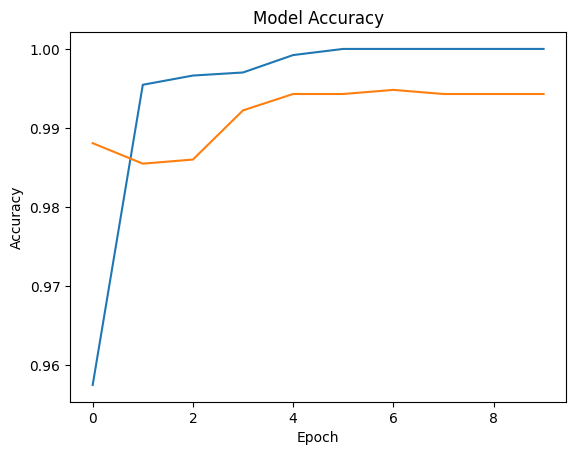

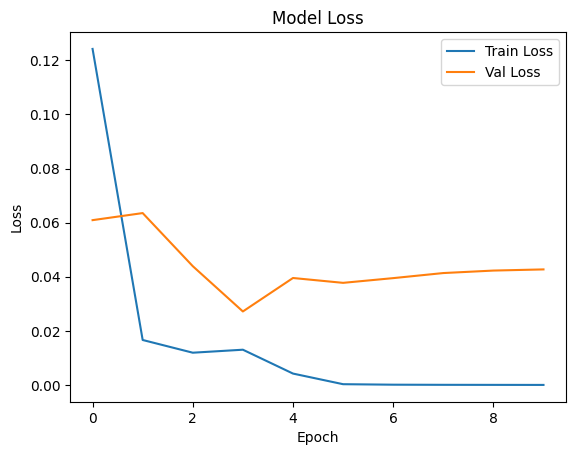

In [65]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [51]:
sample = ["this text for testing"]
sample_sequence = tokenizer.texts_to_sequences([clean_text(sample[0])])
padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_length, padding='post')
predicted_label = model.predict(padded_sample_sequence)
print("Predicted label:", encoder.inverse_transform([predicted_label.argmax()]))

1/1 [==============================] - 1s 525ms/step
Predicted label: ['ham']


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

1- in the text preprocessing i tried to remove the links and any charachters also i lower case the text and stemming them what i mean by this is that it takes the root of the word an i've dealed with the imbalnced labels .
2-i've choose it because i thought it's more sutiable

3- i try different things but i think this was the BEST

4-to see how the model is working well or not

5-yes it might be overfitting

6-i would maybe work more in preprocessing and try try different things